## **Carga de datos**

In [24]:
import pandas as pd

df = pd.read_csv("full_multilabel_df.csv")
df.fillna(0, inplace=True)

In [25]:
index_out = df[df['database'] == 'ESC'].index.tolist()
# Drop indices from DataFrame
df.drop(index_out, inplace=True)
df.reset_index(drop=True, inplace=True)

In [26]:
df['database'].value_counts()

database
INTER1SP    6041
SMC         5129
EMS         2005
EW          1992
MESD         862
EmoFilm      359
Name: count, dtype: int64

In [27]:
import numpy as np

features = np.load("full_multilabel_w2v2_53es_layer6.npz")
features = list(features.values())

In [28]:
# Remove corresponding indices from features
features = np.delete(features, index_out, axis=0)

In [29]:
# Verify alignment
assert len(df) == features.shape[0], "Mismatch between df and features length"

## **Preparación de datos**

### **Añadir tipo de muestra (actuada o natural)**

In [30]:
n_dbs = ['SMC', 'ESCorpus']
a_dbs = ['EMS', 'MESD', 'INTER1SP', 'EmoFilm']
i_dbs = ['EmoWisconsin']

df['type_emotion'] = df['database'].apply(lambda x: 'natural' if x in n_dbs else ('acted' if x in a_dbs else 'induced'))

In [31]:
e_dbs = ['SMC', 'EMS', 'INTER1SP', 'EmoFilm']
m_dbs = ['EmoWisconsin', 'MESD', ]

df['accent'] = df['database'].apply(lambda x: 'spain' if x in e_dbs else 'mex')

In [32]:
# Codificar emociones y género como variables dummy (0/1)
y_emotion = pd.get_dummies(df["new_emotion"])  
y_gender = pd.get_dummies(df["gender"])        
y_accent = pd.get_dummies(df["accent"]) 

# Unir ambos en una sola matriz de salida
y = pd.concat([y_emotion, y_gender, y_accent], axis=1).values

In [33]:
from sklearn.model_selection import train_test_split

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42, shuffle=True, stratify=df['new_emotion'])

# Extraer las rutas correspondientes al conjunto de prueba
_, test_paths = train_test_split(df["path"], test_size=0.2, random_state=42)
test_paths = test_paths.reset_index(drop=True)

# Obtener los mismos índices que se usaron en el split original
indices = np.arange(len(df))

# Reproducir el split usando solo índices
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

# Ahora puedes indexar cualquier columna del DataFrame original
test_databases = df.iloc[test_idx]['database'].reset_index(drop=True)

In [34]:
from sklearn.preprocessing import StandardScaler

# Escalado de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Convierte explícitamente las etiquetas
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [35]:
X_train.shape, y_train.shape

((13110, 1024), (13110, 12))

## **Entrenamiento**
1. Grid-Search Cross-validation Multioutput
2. Basado en Macro-F1
3. Entrenamiento en Chain


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Escalado de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Definición del modelo base ---
base_mlp = MLPClassifier(max_iter=500, random_state=42)

# --- Búsqueda de hiperparámetros ---
param_grid = {
    'estimator__hidden_layer_sizes': [(512, 256, 256), (512, 512, 256), (512, 512, 512, 256)],
    'estimator__activation': ['relu'],
    'estimator__learning_rate_init': [0.001, 0.0005, 0.0001],
    'estimator__alpha': [0.0001, 0.001],
}

# --- Clasificador multietiqueta ---
multioutput = MultiOutputClassifier(base_mlp)

# --- Métrica de evaluación (F1 macro promedio sobre etiquetas) ---
f1_weighted_scorer = make_scorer(f1_score, average='weighted')

# --- GridSearchCV ---
grid_search = GridSearchCV(
    estimator=multioutput,
    param_grid=param_grid,
    scoring=f1_weighted_scorer,
    cv=3,
    verbose=3,
    n_jobs=-1  # paraleliza en todos los cores disponibles
)

In [ ]:
# --- Entrenamiento ---
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\model_selection\_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


GridSearchCV(cv=3,
             estimator=MultiOutputClassifier(estimator=MLPClassifier(max_iter=500,
                                                                     random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__activation': ['relu'],
                         'estimator__alpha': [0.0001, 0.001],
                         'estimator__hidden_layer_sizes': [(512, 256, 256),
                                                           (512, 512, 256),
                                                           (512, 512, 512,
                                                            256)],
                         'estimator__learning_rate_init': [0.001, 0.0005,
                                                           0.0001]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=3)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

# --- Resultados ---
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nF1-score (weighted) en el set de prueba:")
y_pred = grid_search.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))

# ====================================
# 5. Reportes separados: Emociones y Género
# ====================================

# Separar emociones (columnas 0-6) y género (columnas 7-9)
y_test_emotions = y_test[:, :7]
y_test_gender = y_test[:, 7:10]
y_test_accent = y_test[:, 10:]

y_pred_emotions = y_pred[:, :7]
y_pred_gender = y_pred[:, 7:10]
y_pred_accent = y_pred[:, 10:]

emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
gender_labels = ['female', 'male', 'child']
accent_labels = ['mex', 'spain']

# ======= Reporte Emociones ========
print("\n===== Reporte de EMOCIONES =====")

print("\nClassification Report (Emociones):")
print(classification_report(y_test_emotions, y_pred_emotions, target_names=emotion_labels, digits=6))

print("Accuracy (Emociones):", accuracy_score(y_test_emotions, y_pred_emotions))
print("Hamming Loss (Emociones):", hamming_loss(y_test_emotions, y_pred_emotions))
print("F1 weighted (Emociones):", f1_score(y_test_emotions, y_pred_emotions, average="weighted"))

# ======= Reporte Género ========a
print("\n===== Reporte de GÉNERO =====")

print("\nClassification Report (Género):")
print(classification_report(y_test_gender, y_pred_gender, target_names=gender_labels, digits=6))

print("Accuracy (Género):", accuracy_score(y_test_gender, y_pred_gender))
print("Hamming Loss (Género):", hamming_loss(y_test_gender, y_pred_gender))
print("F1 weighted (Género):", f1_score(y_test_gender, y_pred_gender, average="weighted"))

# ======= Reporte tipo ========a
print("\n===== Reporte de TIPO =====")

print("\nClassification Report (Acento):")
print(classification_report(y_test_accent, y_pred_accent, target_names=accent_labels, digits=6))

print("Accuracy (Género):", accuracy_score(y_test_accent, y_pred_accent))
print("Hamming Loss (Género):", hamming_loss(y_test_accent, y_pred_accent))
print("F1 weighted (Género):", f1_score(y_test_accent, y_pred_accent, average="weighted"))

Mejores hiperparámetros encontrados:
{'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (512, 256, 256), 'estimator__learning_rate_init': 0.001}

F1-score (weighted) en el set de prueba:
0.9654171060105439

===== Reporte de EMOCIONES =====

Classification Report (Emociones):
              precision    recall  f1-score   support

       anger   0.900000  0.858247  0.878628       388
     disgust   0.919908  0.887417  0.903371       453
        fear   0.849711  0.814404  0.831683       361
   happiness   0.902235  0.845550  0.872973       382
     neutral   0.932856  0.933692  0.933274      1116
     sadness   0.942363  0.876676  0.908333       373
    surprise   0.914692  0.941463  0.927885       205

   micro avg   0.914626  0.888957  0.901609      3278
   macro avg   0.908824  0.879636  0.893735      3278
weighted avg   0.914398  0.888957  0.901283      3278
 samples avg   0.873551  0.888957  0.878686      3278

Accuracy (Emociones): 0.85814

c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import hamming_loss, accuracy_score

# Hamming Loss: porcentaje de etiquetas mal clasificadas (por etiqueta)
hl = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hl:.4f}")

# Exact Match Ratio (Subset Accuracy): solo acierta si TODAS las etiquetas coinciden
emr = accuracy_score(y_test, y_pred)
print(f"Exact Match Ratio: {emr:.4f}")


Hamming Loss: 0.0170
Exact Match Ratio: 0.8551


## **Re-entrenamiento sin Chain**

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# --- Definición del modelo base ---
base_mlp = MLPClassifier(
                        activation='relu',
                        alpha=0.0001,
                        hidden_layer_sizes=(512, 256, 256),
                        learning_rate_init=0.001,
                        max_iter=1000,
                        random_state=42,)


# --- Clasificador multietiqueta ---
multioutput = MultiOutputClassifier(base_mlp, n_jobs=-1)

multioutput.fit(X_train, y_train)

MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=(512, 256,
                                                                  256),
                                              max_iter=1000, random_state=42),
                      n_jobs=-1)

In [37]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss



print("\nF1-score (weighted) en el set de prueba:")
y_pred = multioutput.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))

# ====================================
# 5. Reportes separados: Emociones y Género
# ====================================

y_test_emotions = y_test[:, :7]
y_test_gender = y_test[:, 7:10]
y_test_accent = y_test[:, 10:]

y_pred_emotions = y_pred[:, :7]
y_pred_gender = y_pred[:, 7:10]
y_pred_accent = y_pred[:, 10:]


emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
gender_labels =  ['child', 'female', 'male']
accent_labels = ['mex', 'spain']

# ======= Reporte Emociones ========
print("\n===== Reporte de EMOCIONES =====")

print("\nClassification Report (Emociones):")
print(classification_report(y_test_emotions, y_pred_emotions, target_names=emotion_labels, digits=6))

print("Accuracy (Emociones):", accuracy_score(y_test_emotions, y_pred_emotions))
print("Hamming Loss (Emociones):", hamming_loss(y_test_emotions, y_pred_emotions))
print("F1 weighted (Emociones):", f1_score(y_test_emotions, y_pred_emotions, average="weighted"))

# ======= Reporte Género ========a
print("\n===== Reporte de GÉNERO =====")

print("\nClassification Report (Género):")
print(classification_report(y_test_gender, y_pred_gender, target_names=gender_labels, digits=6))

print("Accuracy (Género):", accuracy_score(y_test_gender, y_pred_gender))
print("Hamming Loss (Género):", hamming_loss(y_test_gender, y_pred_gender))
print("F1 weighted (Género):", f1_score(y_test_gender, y_pred_gender, average="weighted"))

# ======= Reporte tipo ========a
print("\n===== Reporte de TIPO =====")

print("\nClassification Report (Acento):")
print(classification_report(y_test_accent, y_pred_accent, target_names=accent_labels, digits=6))

print("Accuracy (Género):", accuracy_score(y_test_accent, y_pred_accent))
print("Hamming Loss (Género):", hamming_loss(y_test_accent, y_pred_accent))
print("F1 weighted (Género):", f1_score(y_test_accent, y_pred_accent, average="weighted"))


F1-score (weighted) en el set de prueba:
0.9652044781663428

===== Reporte de EMOCIONES =====

Classification Report (Emociones):
              precision    recall  f1-score   support

       anger   0.887139  0.871134  0.879064       388
     disgust   0.925000  0.898455  0.911534       453
        fear   0.860870  0.822715  0.841360       361
   happiness   0.928571  0.850785  0.887978       382
     neutral   0.921218  0.922043  0.921630      1116
     sadness   0.939655  0.876676  0.907074       373
    surprise   0.926829  0.926829  0.926829       205

   micro avg   0.914313  0.888652  0.901300      3278
   macro avg   0.912755  0.881234  0.896496      3278
weighted avg   0.914366  0.888652  0.901104      3278
 samples avg   0.873754  0.888652  0.878686      3278

Accuracy (Emociones): 0.8590604026845637
Hamming Loss (Emociones): 0.027804410354745925
F1 weighted (Emociones): 0.9011036690961702

===== Reporte de GÉNERO =====

Classification Report (Género):
              precisio

c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Separar las predicciones ---
n_emotions = y_emotion.shape[1]
n_gender = y_gender.shape[1]
n_accent = y_accent.shape[1]

emotion_true = np.argmax(y_test[:, :n_emotions], axis=1)
emotion_pred = np.argmax(y_pred[:, :n_emotions], axis=1)

# --- Obtener etiquetas predichas y verdaderas ---
gender_true = np.argmax(y_test[:, n_emotions:n_gender + n_emotions], axis=1)
gender_pred = np.argmax(y_pred[:, n_emotions:n_gender + n_emotions], axis=1)

accent_true = np.argmax(y_test[:, n_gender + n_emotions:], axis=1)
accent_pred = np.argmax(y_pred[:, n_gender + n_emotions:], axis=1)


=== Classification Report for EMS ===
              precision    recall  f1-score   support

       anger     0.7042    0.9434    0.8065        53
     disgust     0.9412    0.8571    0.8972        56
        fear     0.9024    0.8810    0.8916        42
   happiness     0.9762    0.8542    0.9111        48
     neutral     0.9512    0.9435    0.9474       124
     sadness     0.9394    0.8611    0.8986        36
    surprise     1.0000    0.9167    0.9565        24

    accuracy                         0.9034       383
   macro avg     0.9164    0.8939    0.9013       383
weighted avg     0.9153    0.9034    0.9059       383

Accuracy: 0.9034
Hamming Loss: 0.0966
Weighted F1-score: 0.9059
Micro F1-score:    0.9034


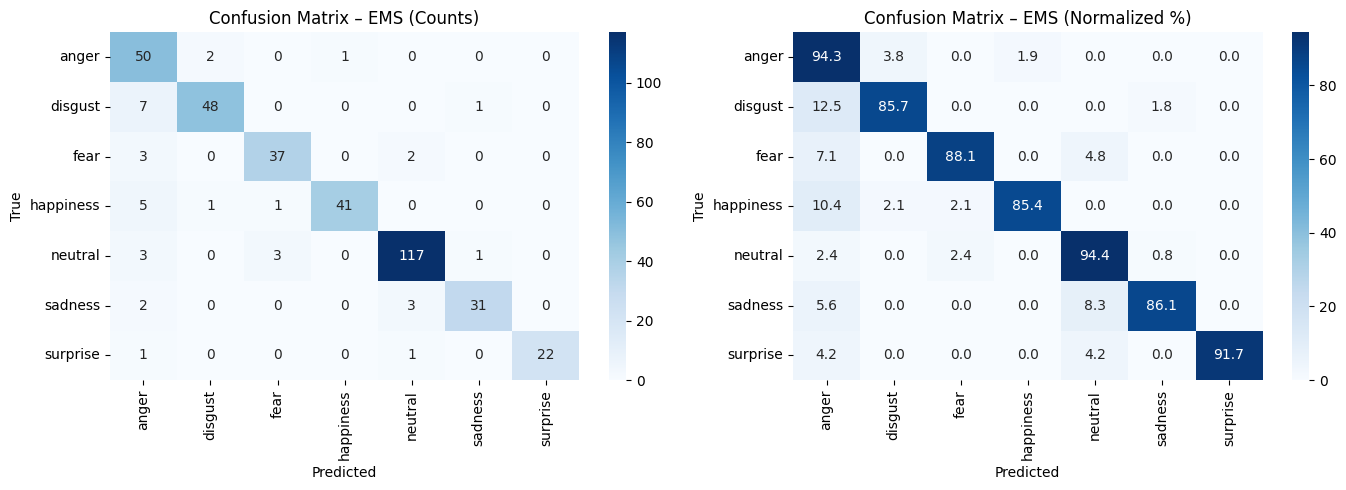


=== Classification Report for EW ===
              precision    recall  f1-score   support

       anger     0.6154    0.9302    0.7407        43
     disgust     0.9074    0.8448    0.8750        58
        fear     0.8529    0.7838    0.8169        37
   happiness     0.9286    0.8864    0.9070        44
     neutral     0.9370    0.9015    0.9189       132
     sadness     0.9474    0.8372    0.8889        43
    surprise     1.0000    0.8889    0.9412        27

    accuracy                         0.8750       384
   macro avg     0.8841    0.8675    0.8698       384
weighted avg     0.8930    0.8750    0.8793       384

Accuracy: 0.8750
Hamming Loss: 0.1250
Weighted F1-score: 0.8793
Micro F1-score:    0.8750


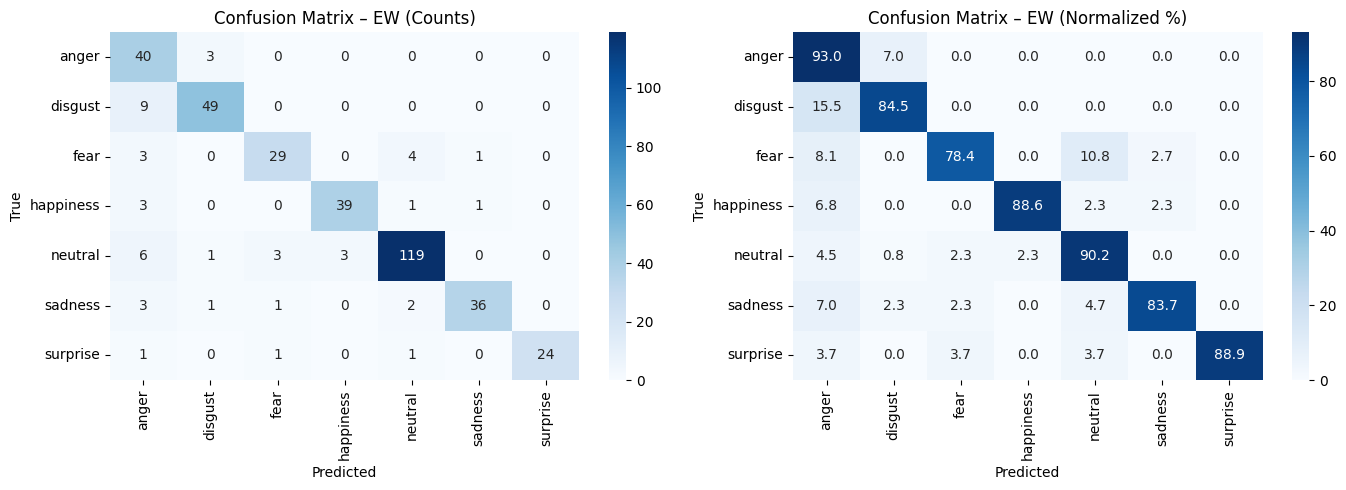


=== Classification Report for EmoFilm ===
              precision    recall  f1-score   support

       anger     0.5714    1.0000    0.7273         8
     disgust     1.0000    0.7778    0.8750         9
        fear     1.0000    0.8000    0.8889        10
   happiness     1.0000    0.5714    0.7273         7
     neutral     0.8889    0.9600    0.9231        25
     sadness     1.0000    0.8750    0.9333         8
    surprise     1.0000    1.0000    1.0000         4

    accuracy                         0.8732        71
   macro avg     0.9229    0.8549    0.8678        71
weighted avg     0.9126    0.8732    0.8763        71

Accuracy: 0.8732
Hamming Loss: 0.1268
Weighted F1-score: 0.8763
Micro F1-score:    0.8732


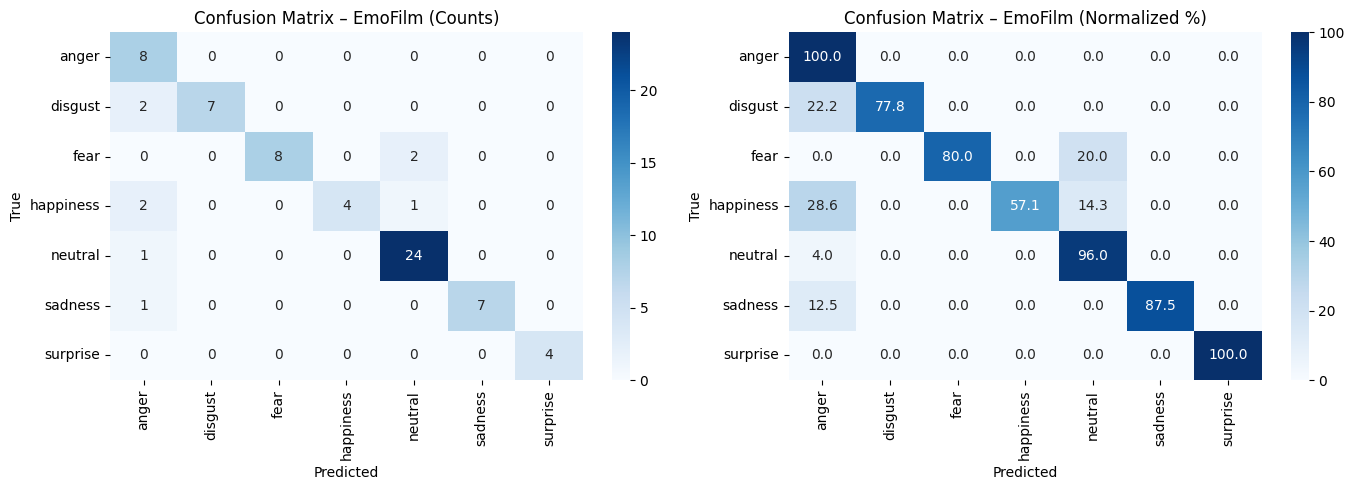


=== Classification Report for INTER1SP ===
              precision    recall  f1-score   support

       anger     0.6667    0.9793    0.7933       145
     disgust     0.9487    0.8916    0.9193       166
        fear     0.8333    0.8148    0.8240       135
   happiness     0.9360    0.8478    0.8897       138
     neutral     0.9375    0.8845    0.9102       407
     sadness     0.9350    0.8394    0.8846       137
    surprise     0.9706    0.9041    0.9362        73

    accuracy                         0.8809      1201
   macro avg     0.8897    0.8802    0.8796      1201
weighted avg     0.8962    0.8809    0.8840      1201

Accuracy: 0.8809
Hamming Loss: 0.1191
Weighted F1-score: 0.8840
Micro F1-score:    0.8809


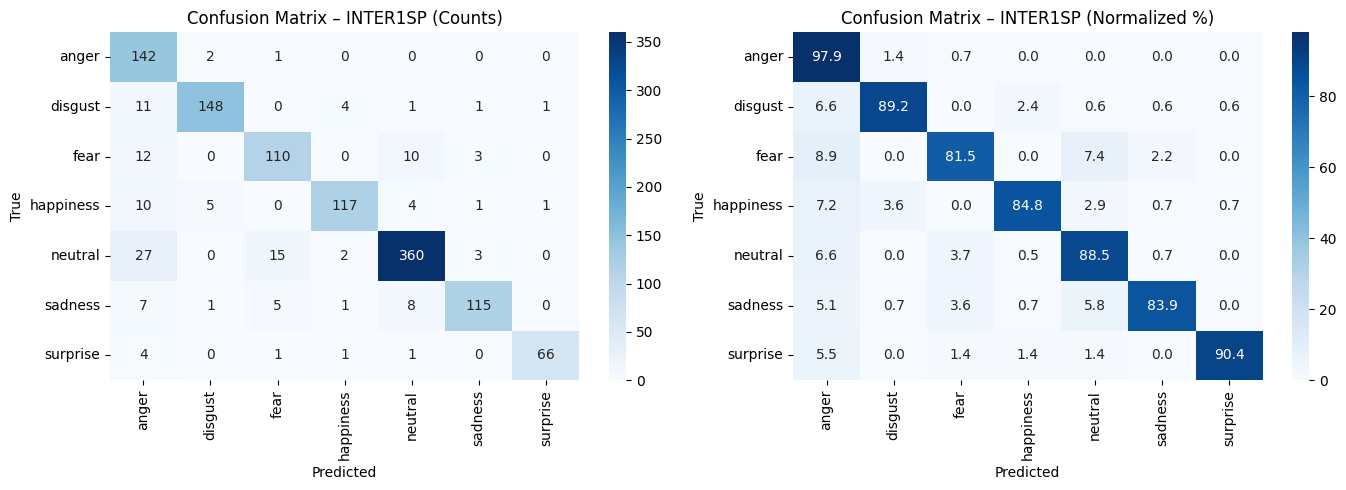


=== Classification Report for MESD ===
              precision    recall  f1-score   support

       anger     0.6000    0.8824    0.7143        17
     disgust     0.8421    0.9412    0.8889        17
        fear     0.8235    0.8235    0.8235        17
   happiness     1.0000    0.7778    0.8750        18
     neutral     0.9552    0.9143    0.9343        70
     sadness     0.9545    0.9130    0.9333        23
    surprise     1.0000    0.8000    0.8889        10

    accuracy                         0.8837       172
   macro avg     0.8822    0.8646    0.8655       172
weighted avg     0.9031    0.8837    0.8881       172

Accuracy: 0.8837
Hamming Loss: 0.1163
Weighted F1-score: 0.8881
Micro F1-score:    0.8837


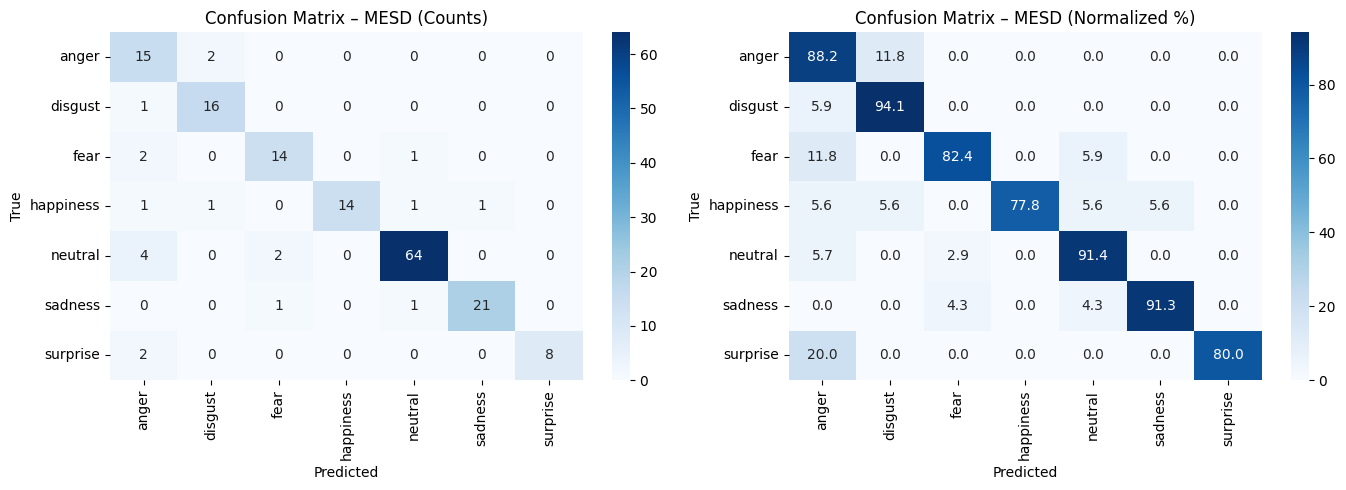


=== Classification Report for SMC ===
              precision    recall  f1-score   support

       anger     0.6075    0.9262    0.7338       122
     disgust     0.9412    0.8707    0.9046       147
        fear     0.8899    0.8083    0.8472       120
   happiness     0.9273    0.8031    0.8608       127
     neutral     0.9246    0.9246    0.9246       358
     sadness     0.9714    0.8095    0.8831       126
    surprise     0.9524    0.8955    0.9231        67

    accuracy                         0.8744      1067
   macro avg     0.8878    0.8626    0.8682      1067
weighted avg     0.8943    0.8744    0.8787      1067

Accuracy: 0.8744
Hamming Loss: 0.1256
Weighted F1-score: 0.8787
Micro F1-score:    0.8744


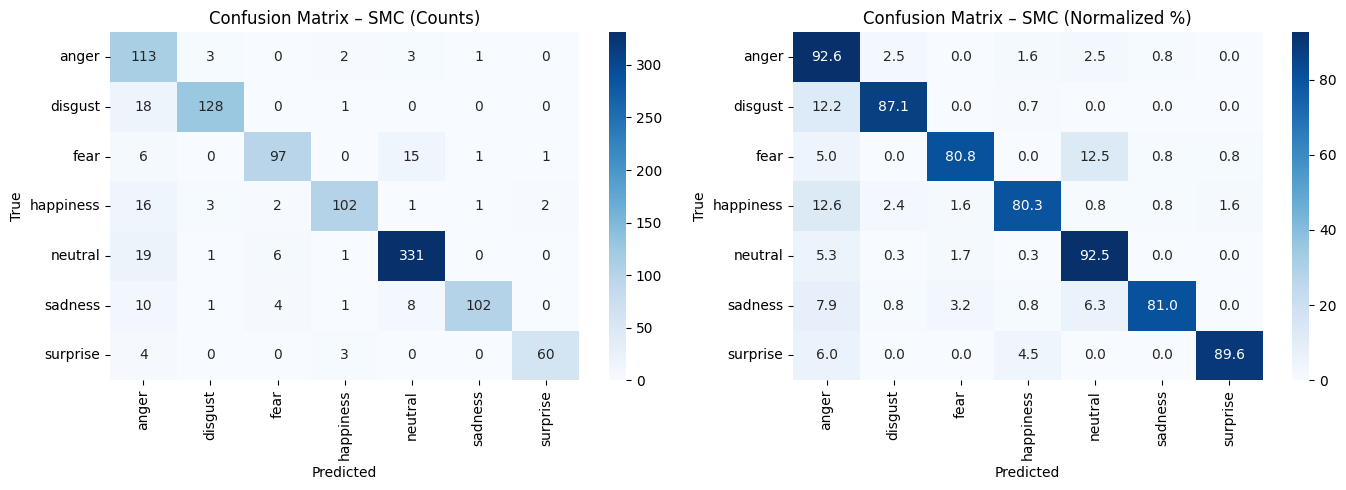

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


unique_dbs = np.unique(test_databases)

for db in unique_dbs:
    # Filtrar muestras por base de datos
    mask = test_databases == db
    emo_t = emotion_true[mask]
    emo_p = emotion_pred[mask]

    print(f"\n=== Classification Report for {db} ===")
    print(classification_report(emo_t, emo_p, target_names=emotion_labels, digits=4))

    print(f"Accuracy: {accuracy_score(emo_t, emo_p):.4f}")
    print(f"Hamming Loss: {hamming_loss(emo_t, emo_p):.4f}")
    print(f"Weighted F1-score: {f1_score(emo_t, emo_p, average='weighted'):.4f}")
    print(f"Micro F1-score:    {f1_score(emo_t, emo_p, average='micro'):.4f}")


    # Confusion matrices
    cm = confusion_matrix(emo_t, emo_p, labels=range(len(emotion_labels)))
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot ambas matrices
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=emotion_labels, yticklabels=emotion_labels,
                cmap='Blues', ax=axes[0])
    axes[0].set_title(f"Confusion Matrix – {db} (Counts)")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    sns.heatmap(cm_norm * 100, annot=True, fmt='.1f',
                xticklabels=emotion_labels, yticklabels=emotion_labels,
                cmap='Blues', ax=axes[1])
    axes[1].set_title(f"Confusion Matrix – {db} (Normalized %)")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

## Resultados por tipo de base de datos


=== Classification Report for acted ===
              precision    recall  f1-score   support

       anger     0.6656    0.9641    0.7875       223
     disgust     0.9399    0.8831    0.9106       248
        fear     0.8535    0.8284    0.8408       204
   happiness     0.9514    0.8341    0.8889       211
     neutral     0.9401    0.9026    0.9209       626
     sadness     0.9405    0.8529    0.8946       204
    surprise     0.9804    0.9009    0.9390       111

    accuracy                         0.8856      1827
   macro avg     0.8959    0.8809    0.8832      1827
weighted avg     0.9007    0.8856    0.8888      1827

Accuracy: 0.8856
Hamming Loss: 0.1144
Weighted F1-score: 0.8888
Micro F1-score:    0.8856


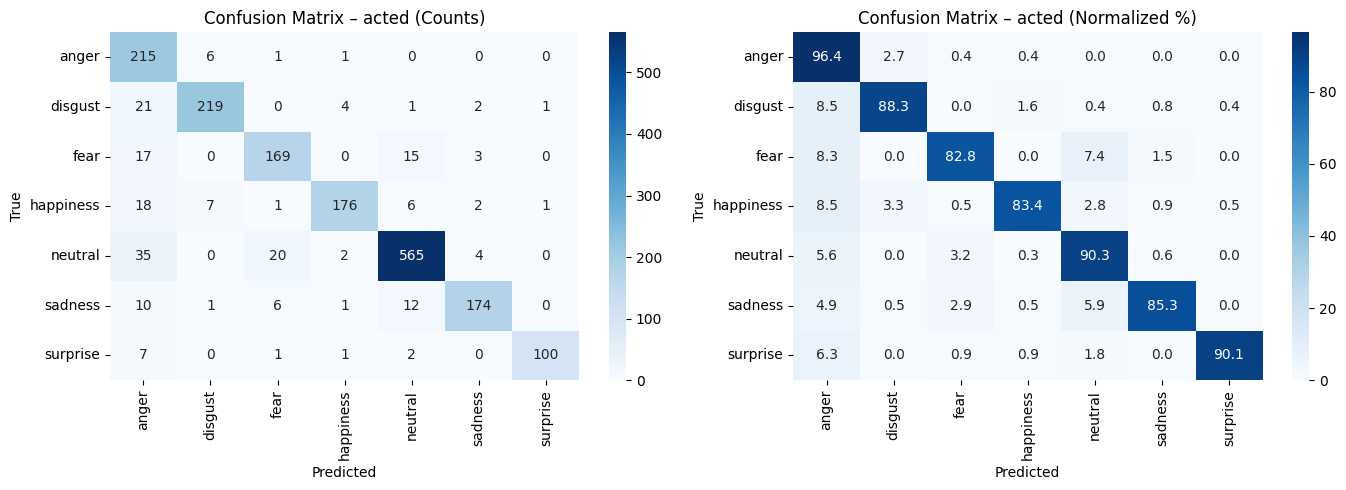


=== Classification Report for induced ===
              precision    recall  f1-score   support

       anger     0.6154    0.9302    0.7407        43
     disgust     0.9074    0.8448    0.8750        58
        fear     0.8529    0.7838    0.8169        37
   happiness     0.9286    0.8864    0.9070        44
     neutral     0.9370    0.9015    0.9189       132
     sadness     0.9474    0.8372    0.8889        43
    surprise     1.0000    0.8889    0.9412        27

    accuracy                         0.8750       384
   macro avg     0.8841    0.8675    0.8698       384
weighted avg     0.8930    0.8750    0.8793       384

Accuracy: 0.8750
Hamming Loss: 0.1250
Weighted F1-score: 0.8793
Micro F1-score:    0.8750


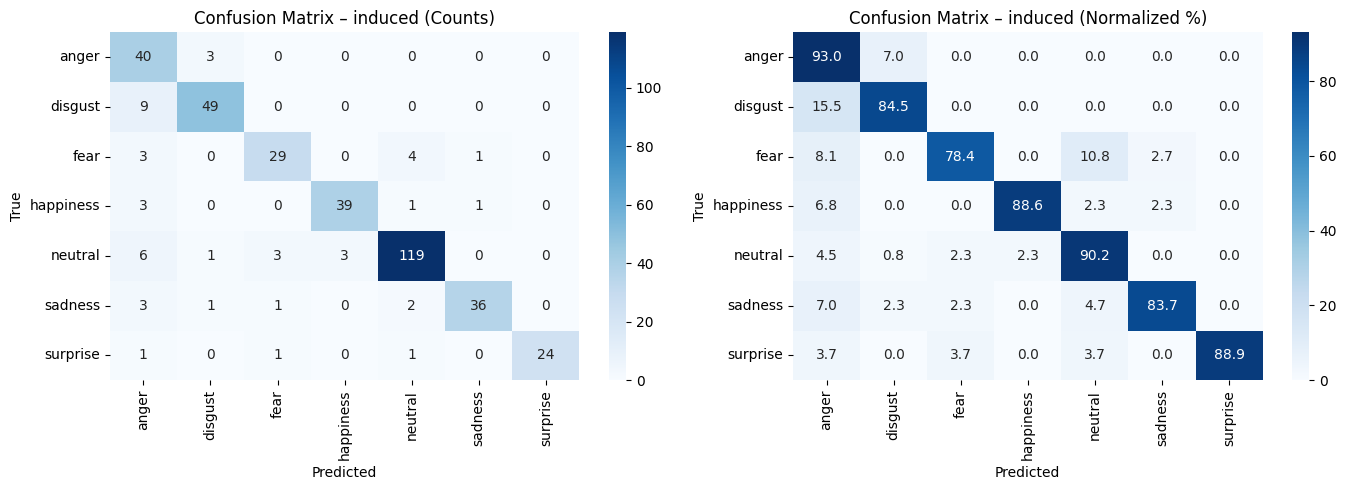


=== Classification Report for natural ===
              precision    recall  f1-score   support

       anger     0.6075    0.9262    0.7338       122
     disgust     0.9412    0.8707    0.9046       147
        fear     0.8899    0.8083    0.8472       120
   happiness     0.9273    0.8031    0.8608       127
     neutral     0.9246    0.9246    0.9246       358
     sadness     0.9714    0.8095    0.8831       126
    surprise     0.9524    0.8955    0.9231        67

    accuracy                         0.8744      1067
   macro avg     0.8878    0.8626    0.8682      1067
weighted avg     0.8943    0.8744    0.8787      1067

Accuracy: 0.8744
Hamming Loss: 0.1256
Weighted F1-score: 0.8787
Micro F1-score:    0.8744


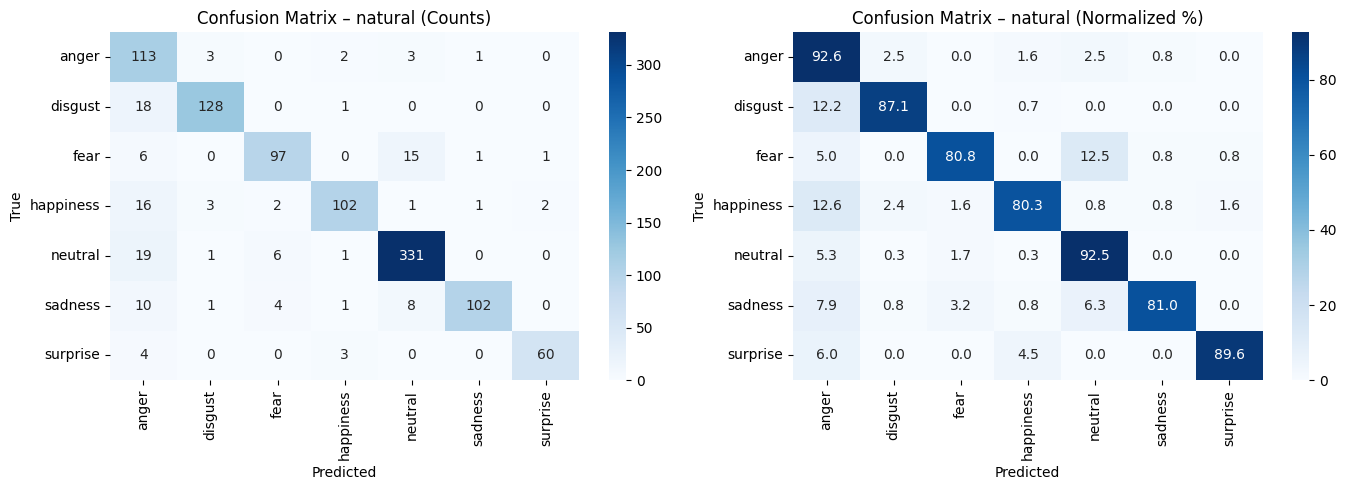

In [40]:
# Ahora puedes indexar cualquier columna del DataFrame original
test_types = df.iloc[test_idx]['type_emotion'].reset_index(drop=True)


unique_types = np.unique(test_types)

for db in unique_types:
    # Filtrar muestras por base de datos
    mask = test_types == db
    emo_t = emotion_true[mask]
    emo_p = emotion_pred[mask]

    print(f"\n=== Classification Report for {db} ===")
    print(classification_report(emo_t, emo_p, target_names=emotion_labels, digits=4))

    print(f"Accuracy: {accuracy_score(emo_t, emo_p):.4f}")
    print(f"Hamming Loss: {hamming_loss(emo_t, emo_p):.4f}")
    print(f"Weighted F1-score: {f1_score(emo_t, emo_p, average='weighted'):.4f}")
    print(f"Micro F1-score:    {f1_score(emo_t, emo_p, average='micro'):.4f}")


    # Confusion matrices
    cm = confusion_matrix(emo_t, emo_p, labels=range(len(emotion_labels)))
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot ambas matrices
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=emotion_labels, yticklabels=emotion_labels,
                cmap='Blues', ax=axes[0])
    axes[0].set_title(f"Confusion Matrix – {db} (Counts)")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    sns.heatmap(cm_norm * 100, annot=True, fmt='.1f',
                xticklabels=emotion_labels, yticklabels=emotion_labels,
                cmap='Blues', ax=axes[1])
    axes[1].set_title(f"Confusion Matrix – {db} (Normalized %)")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

## Guardar resultados

In [16]:
import joblib

# Guardar el modelo entrenado
joblib.dump(multioutput, "multioutput_best_model.pkl")

# Guardar el escalador
joblib.dump(scaler, "scaler_multioutput_best_model.pkl")

print("Modelo y escalador guardados correctamente.")

Modelo y escalador guardados correctamente.


## **Entrenamiento Chain**
{'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (512, 256, 256), 'estimator__learning_rate_init': 0.001}


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Escalado de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, f1_score

mlp = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    hidden_layer_sizes=(512, 256, 256),
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
)


chain = ClassifierChain(mlp, chain_method='predict_proba', verbose=True)


chain.fit(X_train, y_train)


[Chain] .................. (1 of 12) Processing order 0, total= 1.0min
[Chain] .................. (2 of 12) Processing order 1, total=  49.5s
[Chain] .................. (3 of 12) Processing order 2, total=  54.1s
[Chain] .................. (4 of 12) Processing order 3, total=  45.0s
[Chain] .................. (5 of 12) Processing order 4, total=  53.0s
[Chain] .................. (6 of 12) Processing order 5, total=  54.4s
[Chain] .................. (7 of 12) Processing order 6, total=  47.4s
[Chain] .................. (8 of 12) Processing order 7, total=  35.0s
[Chain] .................. (9 of 12) Processing order 8, total=  38.9s
[Chain] ................. (10 of 12) Processing order 9, total=  37.9s
[Chain] ................ (11 of 12) Processing order 10, total=  22.6s
[Chain] ................ (12 of 12) Processing order 11, total=  29.4s


ClassifierChain(base_estimator=MLPClassifier(hidden_layer_sizes=(512, 256, 256),
                                             max_iter=1000, random_state=42),
                chain_method='predict_proba', verbose=True)

In [21]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

print("\nF1-score (weighted) en el set de prueba:")
y_pred = chain.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))

# ====================================
# 5. Reportes separados: Emociones y Género
# ====================================

# Separar emociones (columnas 0-6) y género (columnas 7-9)
y_test_gender = y_test[:, 7:10]
y_test_accent = y_test[:, 10:]
y_test_emotions = y_test[:, :7]

y_pred_gender = y_pred[:, 7:10]
y_pred_accent = y_pred[:, 10:]
y_pred_emotions = y_pred[:, :7]

emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
gender_labels = ['female', 'male', 'child']
accent_labels = ['mex', 'spain']

# ======= Reporte Emociones ========
print("\n===== Reporte de EMOCIONES =====")

print("\nClassification Report (Emociones):")
print(classification_report(y_test_emotions, y_pred_emotions, target_names=emotion_labels, digits=6))

print("Accuracy (Emociones):", accuracy_score(y_test_emotions, y_pred_emotions))
print("Hamming Loss (Emociones):", hamming_loss(y_test_emotions, y_pred_emotions))
print("F1 weighted (Emociones):", f1_score(y_test_emotions, y_pred_emotions, average="weighted"))

# ======= Reporte Género ========a
print("\n===== Reporte de GÉNERO =====")

print("\nClassification Report (Género):")
print(classification_report(y_test_gender, y_pred_gender, target_names=gender_labels,  digits=6))

print("Accuracy (Género):", accuracy_score(y_test_gender, y_pred_gender))
print("Hamming Loss (Género):", hamming_loss(y_test_gender, y_pred_gender))
print("F1 weighted (Género):", f1_score(y_test_gender, y_pred_gender, average="weighted"))

# ======= Reporte tipo ========a
print("\n===== Reporte de TIPO =====")

print("\nClassification Report (Acento):")
print(classification_report(y_test_accent, y_pred_accent, target_names=accent_labels, digits=6))

print("Accuracy (Género):", accuracy_score(y_test_accent, y_pred_accent))
print("Hamming Loss (Género):", hamming_loss(y_test_accent, y_pred_accent))
print("F1 weighted (Género):", f1_score(y_test_accent, y_pred_accent, average="weighted"))


F1-score (weighted) en el set de prueba:
0.9670506406045736

===== Reporte de EMOCIONES =====

Classification Report (Emociones):
              precision    recall  f1-score   support

       anger   0.900000  0.858247  0.878628       388
     disgust   0.919643  0.909492  0.914539       453
        fear   0.847025  0.828255  0.837535       361
   happiness   0.924581  0.866492  0.894595       382
     neutral   0.927369  0.938172  0.932739      1116
     sadness   0.934844  0.884718  0.909091       373
    surprise   0.913876  0.931707  0.922705       205

   micro avg   0.913975  0.897804  0.905817      3278
   macro avg   0.909620  0.888155  0.898548      3278
weighted avg   0.913896  0.897804  0.905571      3278
 samples avg   0.887126  0.897804  0.890685      3278

Accuracy (Emociones): 0.8764490543014033
Hamming Loss (Emociones): 0.02667131526191929
F1 weighted (Emociones): 0.905571070053286

===== Reporte de GÉNERO =====

Classification Report (Género):
              precision 

c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

# **Gráficas**

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Separar las predicciones ---
n_emotions = y_emotion.shape[1]
n_gender = y_gender.shape[1]
n_accent = y_accent.shape[1]

# --- Obtener etiquetas predichas y verdaderas ---
gender_true = np.argmax(y_test[:, :n_gender], axis=1)
gender_pred = np.argmax(y_pred[:, :n_gender], axis=1)

accent_true = np.argmax(y_test[:, n_gender:n_gender + n_accent], axis=1)
accent_pred = np.argmax(y_pred[:, n_gender:n_gender + n_accent], axis=1)

emotion_true = np.argmax(y_test[:, n_gender + n_accent:], axis=1)
emotion_pred = np.argmax(y_pred[:, n_gender + n_accent:], axis=1)

emotion_labels = y_emotion.columns.tolist()
gender_labels = ['child', 'female', 'male']
accent_labels = y_accent.columns.tolist()

C:\Users\AlxMa\AppData\Local\Temp\ipykernel_10116\746658035.py:6: RuntimeWarning: invalid value encountered in divide
  cm_emotion_norm = cm_emotion.astype('float') / cm_emotion.sum(axis=1, keepdims=True)


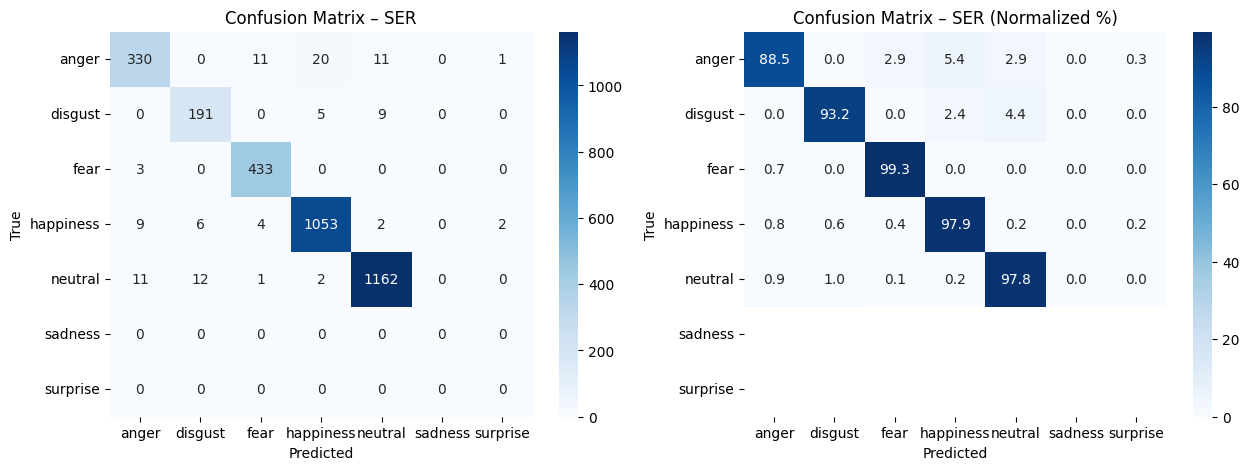

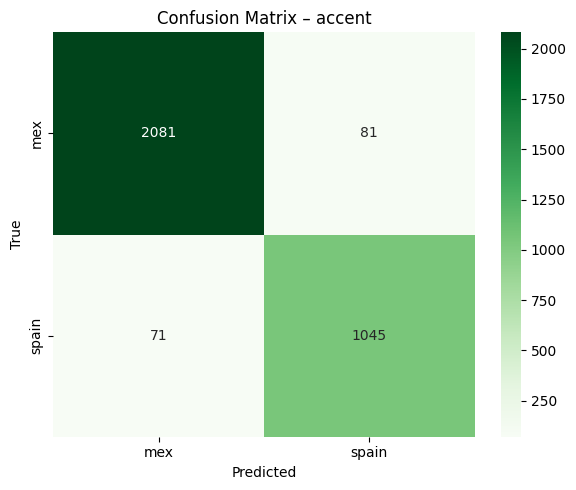

In [23]:
# --- Heatmap para emociones ---
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------
cm_emotion = confusion_matrix(emotion_true, emotion_pred, labels=range(len(emotion_labels)))
cm_emotion_norm = cm_emotion.astype('float') / cm_emotion.sum(axis=1, keepdims=True)


# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(cm_emotion, annot=True, fmt='d', 
            xticklabels=emotion_labels, yticklabels=emotion_labels, 
            cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix – SER")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_emotion_norm * 100, annot=True, fmt='.1f',
            xticklabels=emotion_labels, yticklabels=emotion_labels, 
            cmap='Blues', ax=axes[1])
axes[1].set_title("Confusion Matrix – SER (Normalized %)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")




# --- Heatmap para género ---
cm_accent = confusion_matrix(accent_true, accent_pred, labels=range(len(accent_labels)))
cm_accent_norm = cm_accent.astype('float') / cm_accent.sum(axis=1, keepdims=True)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_accent, annot=True, fmt='d', xticklabels=accent_labels, yticklabels=accent_labels, cmap='Greens')
plt.title("Confusion Matrix – accent")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


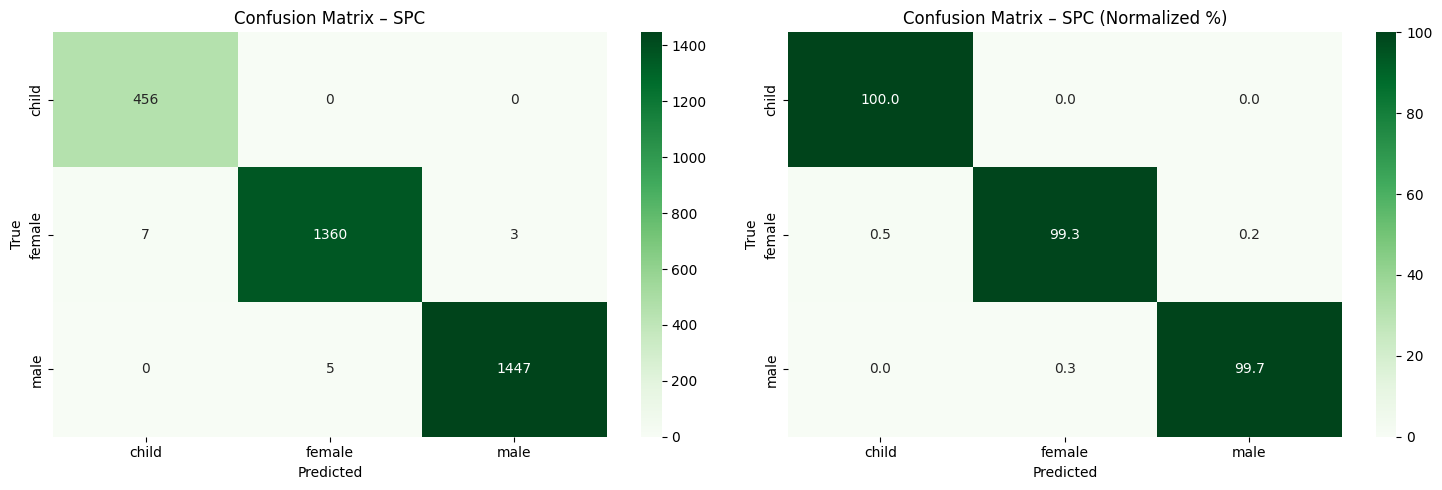

In [17]:
# --- Heatmap para género ---
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cm_gender = confusion_matrix(gender_true, gender_pred, labels=range(len(gender_labels)))
cm_gender_norm = cm_gender.astype('float') / cm_gender.sum(axis=1, keepdims=True)

sns.heatmap(cm_gender, annot=True, fmt='d', 
            xticklabels=gender_labels, yticklabels=gender_labels, 
            cmap='Greens', ax=axes[0])
axes[0].set_title("Confusion Matrix – SPC")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_gender_norm * 100, annot=True, fmt='.1f',
            xticklabels=gender_labels, yticklabels=gender_labels, 
            cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix – SPC (Normalized %)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# Estilo general
plt.tight_layout()
plt.show()

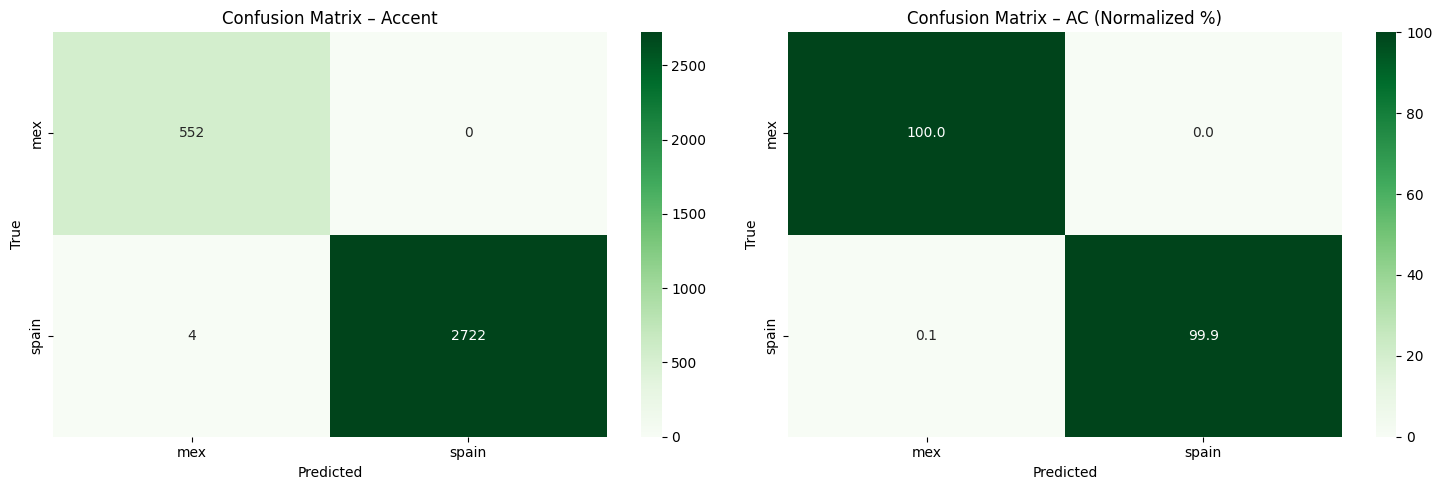

In [18]:
# --- Heatmap para acento ---
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cm_accent = confusion_matrix(accent_true, accent_pred, labels=range(len(accent_labels)))
cm_accent_norm = cm_accent.astype('float') / cm_accent.sum(axis=1, keepdims=True)

sns.heatmap(cm_accent, annot=True, fmt='d', 
            xticklabels=accent_labels, yticklabels=accent_labels, 
            cmap='Greens', ax=axes[0])
axes[0].set_title("Confusion Matrix – Accent")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_accent_norm * 100, annot=True, fmt='.1f',
            xticklabels=accent_labels, yticklabels=accent_labels, 
            cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix – AC (Normalized %)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# Estilo general
plt.tight_layout()
plt.show()

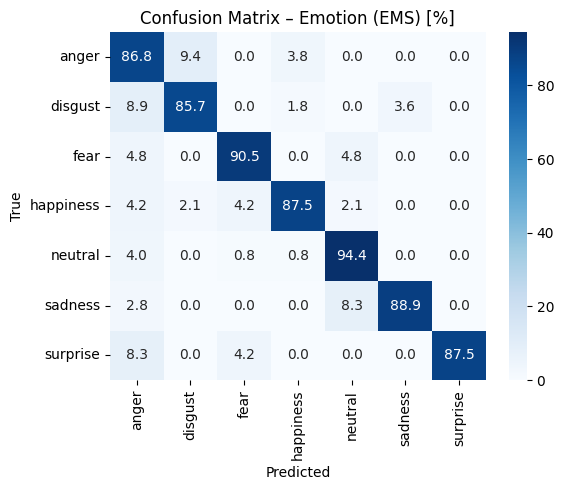

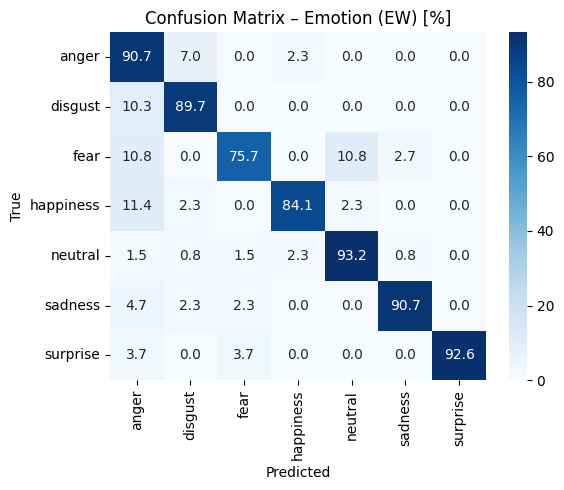

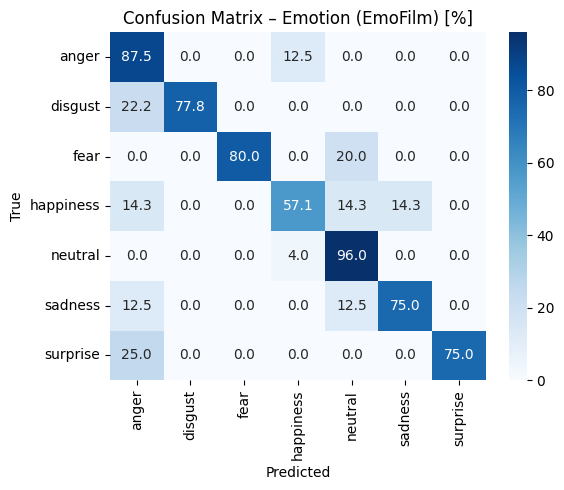

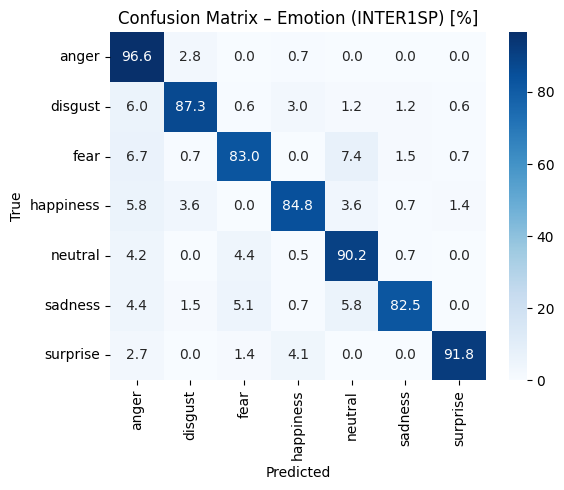

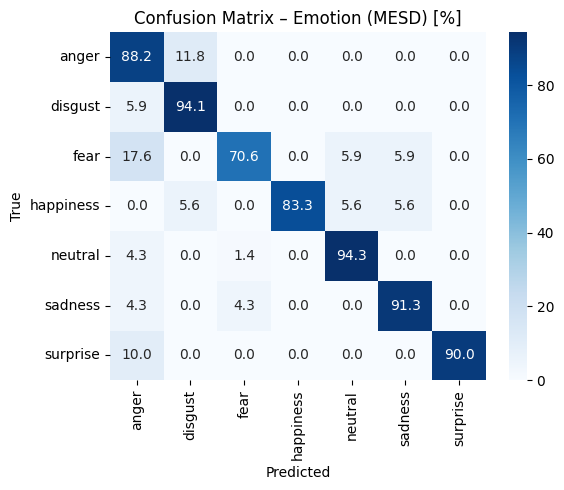

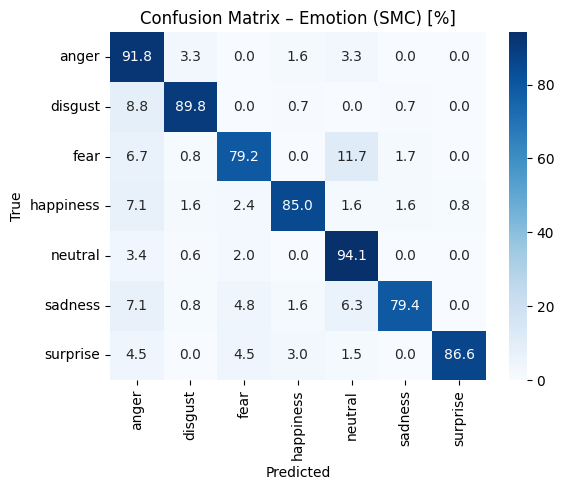

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Base de datos correspondiente a cada muestra
databases = test_databases


# Diccionario para almacenar los heatmaps por base
conf_matrices = {}

for db in np.unique(databases):
    mask = databases == db
    
    # Filtrar por base
    emo_t = emotion_true[mask]
    emo_p = emotion_pred[mask]
    
    # Matriz bruta
    cm = confusion_matrix(emo_t, emo_p, labels=range(len(emotion_labels)))
    
    # Normalizar por filas (por clase real)
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    # Guardar
    conf_matrices[db] = cm_norm

for db in np.unique(databases):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrices[db] * 100, annot=True, fmt='.1f',
                xticklabels=emotion_labels, yticklabels=emotion_labels, cmap='Blues')
    plt.title(f"Confusion Matrix – Emotion ({db}) [%]")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    cm_emotion

---
---
# **Guardar resultados**

In [57]:
results = pd.DataFrame()

results[[l + '_test' for l in emotion_labels]] = y_test_emotions
results[[l + '_pred' for l in emotion_labels]] = y_pred_emotions

results[[l + '_test' for l in gender_labels]] = y_test_gender
results[[l + '_pred' for l in gender_labels]] = y_pred_gender

results[[l + '_test' for l in accent_labels]] = y_test_accent
results[[l + '_pred' for l in accent_labels]] = y_pred_accent

results.index = test_idx

results.to_csv("preds_multioutput.csv")
results

,anger_test,disgust_test,fear_test,happiness_test,neutral_test,sadness_test,surprise_test,anger_pred,disgust_pred,fear_pred,...,child_test,female_test,male_test,child_pred,female_pred,male_pred,mex_test,spain_test,mex_pred,spain_pred
10192,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
6630,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6504,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
16137,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5137,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3208,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
15897,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
13952,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


---
## **Guardar modelo**

In [21]:
import joblib

# Guardar el modelo entrenado
joblib.dump(chain, "chain_multioutput_best.pkl")

# Guardar el escalador
joblib.dump(scaler, "scaler_multioutput_best.pkl")

print("Modelo y escalador guardados correctamente.")

Modelo y escalador guardados correctamente.
